# QUIMB extract phases
Created 26/09/2025

Objectives:
* Use QUIMB to extract SPT phase from boundary operators calculated [here](quimb_save_boundary_operators.ipynb).

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain, combinations
from collections import defaultdict
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
import jax.numpy as jnp

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [10]:
DATA_DIR = r"../../../../data/transverse_cluster_14_site_ed"

In [11]:
def split_full_state_legs(full_state_psi):
    dim = full_state_psi.shape

    num_legs = int(np.log2(dim[0]))
    new_labels = [f'p{i}' for i in range(num_legs)]

    full_state_psi.iset_leg_labels(['(' + '.'.join(new_labels) + ')'])
    full_state_psi = full_state_psi.split_legs([0])
    return full_state_psi

In [12]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [13]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [14]:
psi_dict = dict()

In [15]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )
    #psi = split_full_state_legs(psi)
    
    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

## Gate & circuit functions

In [18]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [19]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

In [20]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ',
                   gate_tag=None, **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.get_uni(transposed=True)

    if gate_tag is not None:
        for t in circ.tensors:
            t.add_tag(gate_tag)

    if first_site != 0:
        index_labels = ['k', 'b']

        index_map = {
            f'{l}{i}': f'{l}{i+first_site}'
            for i in range(n)
            for l in index_labels
        }

        circ.reindex(index_map, inplace=True)

    return circ

In [21]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = left_circuit & right_circuit

    return circ_pair

In [22]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

## Load boundary operators

In [23]:
num_boundary_sites=2
left_most_symmetry_site=4
num_symmetry_sites=6

total_physical_dim = 2**num_boundary_sites

In [24]:
n=2
depth=2
gate2='CZ'

In [25]:
SOL_DIR = r"solutions/"

In [26]:
file_name_pattern = re.compile(r'^\d\.\d_\d\.pickle$')

In [27]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    b, sym_index = file_name.split('_')

    b = float(b)
    sym_index = int(sym_index)
    
    return (b, sym_index)

In [28]:
def generate_circuit_from_params(params, leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth):
    circ_pair = ansatz_circuit_pair(
        leftmost_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        depth
    )

    left_circuit, right_circuit = split_circ_pair(circ_pair)
    left_params, right_params = params

    left_circuit.set_params(left_params)
    right_circuit.set_params(right_params)

    return (left_circuit, right_circuit)

In [29]:
boundary_operator_solutions = dict()
boundary_operator_scores = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            final_score, params = pickle.load(f)

            circ_pair = generate_circuit_from_params(
                params,
                left_most_symmetry_site,
                num_symmetry_sites,
                num_boundary_sites,
                depth
            )
            
            boundary_operator_scores[key] = final_score
            boundary_operator_solutions[key] = circ_pair

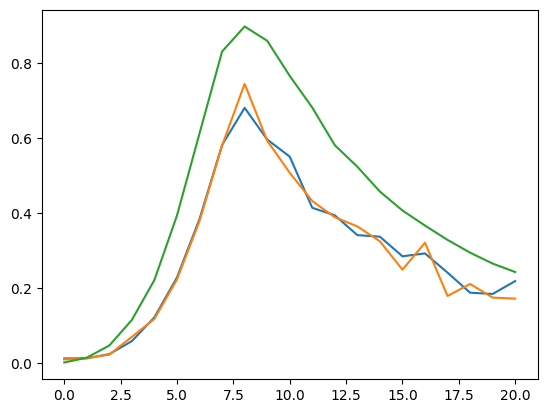

In [30]:
for k in range(1, 4):
    keys = sorted(list(i for i, j in boundary_operator_scores if j == k))
    l = [boundary_operator_scores[(b, k)] for b in keys]
    plt.plot(l)

# Definitions

In [31]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [32]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [33]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [34]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    """
    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )
    """

    tnc = tn.contract()

    return tnc

In [35]:
def generate_rdm(quimb_psi, left_site_index, right_site_index):
    indices_to_map = list(range(left_site_index, right_site_index + 1))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    tn = (quimb_psi & q_bottom)
    tnc = tn.contract()

    return tnc

In [36]:
def generate_boundary_rdms(quimb_psi, leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites):

    left_rdm = generate_rdm(
        quimb_psi,
        leftmost_symmetry_site-num_boundary_sites,
        leftmost_symmetry_site-1
    )

    right_rdm = generate_rdm(
        quimb_psi,
        leftmost_symmetry_site+num_symmetry_sites,
        leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites-1
    )

    return left_rdm, right_rdm

## SPT extraction functions

In [37]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [38]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [39]:
e, a, b, c = symmetry_labels

In [40]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [43]:
def relabel_index(index, old_label, new_label):
    index_tail = index[len(old_label):]
    return new_label + index_tail

In [44]:
def relabel_circuit(circuit_tn, new_k_label, new_b_label, old_k_label='k',
                   old_b_label='b'):
    k_regex = re.compile(rf"^{old_k_label}\d+$")
    b_regex = re.compile(rf"^{old_b_label}\d+$")

    old_k_indices = [
        k for k in circuit_tn.ind_map
        if bool(re.search(k_regex, k))
    ]
    
    old_b_indices = [
        k for k in circuit_tn.ind_map
        if bool(re.search(b_regex, k))
    ]
    
    k_out_indices = [
        relabel_index(i, old_k_label, new_k_label)
        for i in old_k_indices
    ]
        
    b_out_indices = [
        relabel_index(i, old_b_label, new_b_label)
        for i in old_b_indices
    ]

    mapping = dict(
        chain(
            zip(old_k_indices, k_out_indices),
            zip(old_b_indices, b_out_indices)
        )
    )

    circuit_tn.reindex(mapping, inplace=True)

In [45]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    us = [u_g.copy(), u_h.copy(), u_gh.copy()]

    relabel_circuit(us[0], 'k', 'l')
    relabel_circuit(us[1], 'l', 'm')
    relabel_circuit(us[2], 'b', 'm')

    us[2] = us[2].conj()

    out = (rho & us[0] & us[1] & us[2]) ^ ...

    return (out/(np.abs(out)), np.abs(out))

In [51]:
def get_proj_rep_phases(rho, unitaries):
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

# Extract phases

In [48]:
b_params = np.round(np.linspace(0, 2, 21), 3)

In [49]:
leftmost_symmetry_site=left_most_symmetry_site

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [52]:
proj_rep_phases = list()

for t in b_params:
    tenpy_psi = psi_dict[t]

    quimb_psi = qtn.Dense1D(
        tenpy_psi.to_ndarray(),
        phys_dim=2
    )

    left_rdm, right_rdm = generate_boundary_rdms(
        quimb_psi,
        leftmost_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    unitaries = [boundary_operator_solutions[(t, i)] for i in [1,2,3]]

    left_unitaries, right_unitaries = zip(*unitaries)

    left_phases = get_proj_rep_phases(left_rdm, left_unitaries)
    right_phases = get_proj_rep_phases(right_rdm, right_unitaries)

    proj_rep_phases.append([left_phases, right_phases])

In [53]:
proj_rep_phases = np.array(proj_rep_phases)

In [54]:
proj_rep_phases.shape

(21, 2, 6, 2)

In [55]:
b_params

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [56]:
len(b_params)

21

In [58]:
np.round(
    proj_rep_phases[..., ::2, 0]/proj_rep_phases[..., 1::2, 0],
    2
)

array([[[-1.  +0.j  , -1.  +0.j  , -1.  +0.j  ],
        [-1.  +0.j  , -1.  +0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  -0.j  ],
        [-1.  +0.01j, -1.  +0.j  , -1.  -0.j  ]],

       [[-1.  -0.01j, -1.  -0.j  , -1.  -0.j  ],
        [-1.  +0.j  , -1.  +0.j  , -1.  -0.j  ]],

       [[-1.  -0.02j, -1.  -0.02j, -1.  -0.01j],
        [-1.  -0.02j, -1.  -0.j  , -1.  -0.03j]],

       [[-1.  -0.j  , -1.  -0.01j, -1.  +0.j  ],
        [-1.  -0.j  , -1.  -0.01j, -1.  -0.01j]],

       [[-1.  -0.06j, -1.  -0.02j, -1.  -0.02j],
        [-1.  +0.01j, -1.  +0.01j, -1.  +0.02j]],

       [[-1.  +0.05j, -1.  +0.06j, -1.  +0.02j],
        [-1.  -0.06j, -1.  -0.02j, -1.  -0.01j]],

       [[-1.  -0.03j, -1.  +0.04j, -1.  -0.04j],
        [-1.  +0.09j, -0.99-0.14j, -1.  +0.08j]],

       [[ 0.39+0.92j, -0.52+0.85j, -0.67+0.74j],
        [ 0.83-0.56j,  0.62+0.79j,  0.99+0.13j]],

       [[ 0.99-0.16j,  0.99+0.11j,  0.98+0.19j],
        [ 1.  -0.03j,  0.96+0.28j,  1.  -0.01j]],



In [59]:
gauge_invariant_proj_rep_phase = proj_rep_phases[..., ::2, 0]/proj_rep_phases[..., 1::2, 0]

In [60]:
np.round(gauge_invariant_proj_rep_phase[:8], 2)

array([[[-1.  +0.j  , -1.  +0.j  , -1.  +0.j  ],
        [-1.  +0.j  , -1.  +0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  -0.j  ],
        [-1.  +0.01j, -1.  +0.j  , -1.  -0.j  ]],

       [[-1.  -0.01j, -1.  -0.j  , -1.  -0.j  ],
        [-1.  +0.j  , -1.  +0.j  , -1.  -0.j  ]],

       [[-1.  -0.02j, -1.  -0.02j, -1.  -0.01j],
        [-1.  -0.02j, -1.  -0.j  , -1.  -0.03j]],

       [[-1.  -0.j  , -1.  -0.01j, -1.  +0.j  ],
        [-1.  -0.j  , -1.  -0.01j, -1.  -0.01j]],

       [[-1.  -0.06j, -1.  -0.02j, -1.  -0.02j],
        [-1.  +0.01j, -1.  +0.01j, -1.  +0.02j]],

       [[-1.  +0.05j, -1.  +0.06j, -1.  +0.02j],
        [-1.  -0.06j, -1.  -0.02j, -1.  -0.01j]],

       [[-1.  -0.03j, -1.  +0.04j, -1.  -0.04j],
        [-1.  +0.09j, -0.99-0.14j, -1.  +0.08j]]])

In [61]:
np.round(gauge_invariant_proj_rep_phase[8:], 2)

array([[[ 0.39+0.92j, -0.52+0.85j, -0.67+0.74j],
        [ 0.83-0.56j,  0.62+0.79j,  0.99+0.13j]],

       [[ 0.99-0.16j,  0.99+0.11j,  0.98+0.19j],
        [ 1.  -0.03j,  0.96+0.28j,  1.  -0.01j]],

       [[ 1.  -0.j  ,  1.  +0.01j,  1.  -0.01j],
        [ 1.  -0.01j,  1.  -0.03j,  1.  -0.01j]],

       [[ 0.98-0.21j,  1.  +0.01j,  1.  +0.07j],
        [ 1.  -0.01j,  1.  +0.01j,  1.  -0.01j]],

       [[ 1.  +0.j  ,  1.  -0.j  ,  1.  +0.02j],
        [ 1.  +0.j  ,  1.  -0.j  ,  1.  +0.03j]],

       [[ 1.  -0.01j,  1.  -0.05j,  1.  +0.j  ],
        [ 0.99+0.12j,  0.99+0.11j,  1.  +0.06j]],

       [[ 1.  +0.04j,  1.  -0.02j,  1.  +0.02j],
        [ 1.  -0.01j,  1.  -0.01j,  1.  -0.03j]],

       [[ 1.  +0.01j,  1.  -0.04j,  1.  +0.j  ],
        [ 1.  -0.j  ,  1.  -0.02j,  1.  -0.01j]],

       [[ 1.  +0.01j,  1.  +0.01j,  1.  -0.02j],
        [ 1.  +0.j  ,  1.  -0.j  ,  1.  -0.02j]],

       [[ 1.  +0.01j,  1.  -0.j  ,  1.  -0.02j],
        [ 1.  +0.01j,  1.  +0.02j,  1.  +0.j  ]],



In [62]:
markers = ['<', '>']

In [63]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [64]:
e, a, b, c = symmetry_labels

In [65]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [66]:
side_labels = ['Left', 'Right']

In [67]:
gauge_invariant_proj_rep_real_phase = np.real(gauge_invariant_proj_rep_phase)
mean_gauge_invariant_proj_rep_real_phase = np.mean(gauge_invariant_proj_rep_real_phase, axis=(1,2))
max_gauge_invariant_proj_rep_real_phase = np.max(gauge_invariant_proj_rep_real_phase, axis=(1,2))
min_gauge_invariant_proj_rep_real_phase = np.min(gauge_invariant_proj_rep_real_phase, axis=(1,2))

min_max_gauge_invariant_proj_rep_real_phase = np.stack(
    [
        min_gauge_invariant_proj_rep_real_phase,
        max_gauge_invariant_proj_rep_real_phase
    ],
    axis=0
)

error_gauge_invariant_proj_rep_real_phase = (
    min_max_gauge_invariant_proj_rep_real_phase
    - mean_gauge_invariant_proj_rep_real_phase[np.newaxis, :]
)
error_gauge_invariant_proj_rep_real_phase = np.abs(error_gauge_invariant_proj_rep_real_phase)

In [76]:
np.max(
    np.delete(error_gauge_invariant_proj_rep_real_phase, 8, axis=1)
)

0.028396807112404776

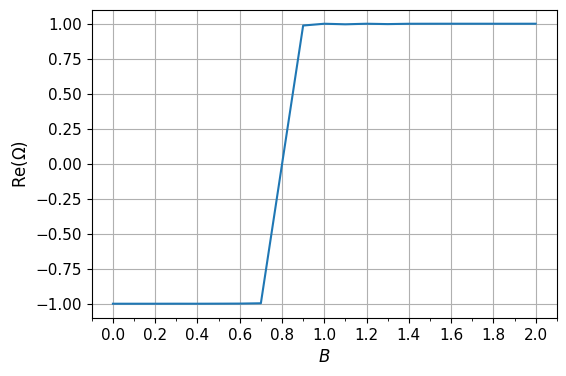

In [71]:
fig, ax = plt.subplots(figsize=(6,4))

"""
plt.errorbar(
    b_params,
    mean_gauge_invariant_proj_rep_real_phase,
    yerr=error_gauge_invariant_proj_rep_real_phase,
    color='tab:blue',
    fmt='-',
    capsize=2
)
"""

ax.plot(
    np.delete(b_params, 8),
    np.delete(mean_gauge_invariant_proj_rep_real_phase, 8),
    color='tab:blue',
)

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)
ax.xaxis.set_minor_locator(
    matplotlib.ticker.MultipleLocator(0.1)
)

"""
ax.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)
"""

ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.grid(
    axis='y',
    which='both'
)
ax.grid(
    axis='x',
    which='major'
)

ax.set_ylabel(r'Re$(\Omega)$', fontsize=12)
ax.set_xlabel('$B$', fontsize=12)

fig.savefig(r'plots/proj_rep_real_phase_from_circ_bosonic.png', dpi=200)

In [77]:
scores = list()
for t in b_params:

    scores.append([boundary_operator_scores[(t, i)] for i in [1,2,3]])

scores = np.array(scores)

In [78]:
overlaps = np.sqrt(1-scores)

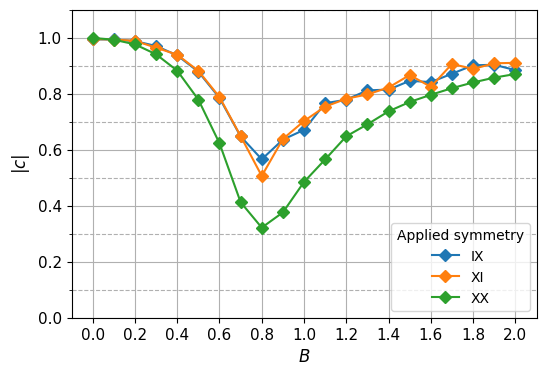

In [79]:
fig, ax = plt.subplots(figsize=(6,4))

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    plt.plot(
        b_params,
        overlaps[:, j],
        color=col,
        label = label,
        marker='D'
    )

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

ax.yaxis.set_minor_locator(
    matplotlib.ticker.MultipleLocator(0.1)
)

#ax.set_yscale('log')
ax.set_ylim(bottom=0, top=1.1)
ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.grid()
ax.grid(
    which='minor',
    axis='y',
    linestyle='--',
    zorder=-1e10
)
ax.set_axisbelow(True)

ax.set_ylabel(r'$\vert c \vert$', fontsize=12)
ax.set_xlabel('$B$', fontsize=12)

ax.legend(loc='lower right', title='Applied symmetry')

#fig.suptitle(r'Final cost $L$ with symmetry $g$ as a function of $B$')

fig.savefig(r'plots/overlaps_from_circ_bosonic.png', dpi=200)

# Conclusion
It's working!